In [1]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pmdarima as pm
from pmdarima import model_selection

from get_forex_data import get_daily_data, get_small_frequencies

from plot import plot_basic_close, pred_vs_real_plot

In [2]:
import yfinance as yf
yf.pdr_override()

In [34]:
PAIR = 'USDJPY'
START = '2023-01-01'
END = '2023-09-09'

## Fetch daily data

In [35]:
df_daily = get_daily_data(PAIR, START, END)

df_daily.tail()

# dataframe to join the prediction table at the end
original_data = df_daily.copy().reset_index(names='date')

original_data['tag'] = 'historical'

original_data = original_data[['date','Adj Close','tag']]

# slice the last two weeks
original_data = original_data.tail(14)

original_data.head()

[*********************100%%**********************]  1 of 1 completed


,date,Adj Close,tag
166,2023-08-22,146.24,historical
167,2023-08-23,145.76,historical
168,2023-08-24,144.67,historical
169,2023-08-25,146.07,historical
170,2023-08-28,146.53,historical


## Plot the close price

In [36]:
# plot_basic_close((15,7), df_daily, PAIR) 

## Get Hourly Data

In [37]:
df_hourly = get_small_frequencies(PAIR, period='30d', interval='1h')
df_hourly.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-09-13 16:00:00+01:00,147.501007,147.546997,147.389999,147.457001,147.457001,0
2023-09-13 17:00:00+01:00,147.457001,147.460007,147.255997,147.345001,147.345001,0
2023-09-13 18:00:00+01:00,147.341995,147.356003,147.162003,147.315994,147.315994,0
2023-09-13 19:00:00+01:00,147.324997,147.447998,147.304001,147.445007,147.445007,0
2023-09-13 20:00:00+01:00,147.445999,147.492004,147.431000,147.481995,147.481995,0


In [48]:
#plot_basic_close((25,10), df_hourly, PAIR)   

## Daily Predicion

In [ ]:
y = df_daily['Adj Close']

In [39]:
y

Date
2023-01-02    130.85
2023-01-03    130.79
2023-01-04    131.25
2023-01-05    132.25
2023-01-06    133.31
               ...  
2023-09-05    146.54
2023-09-06    147.47
2023-09-07    147.71
2023-09-08    147.33
2023-09-11    147.11
Name: Adj Close, Length: 181, dtype: float64

In [40]:

est = pm.ARIMA(order=(1, 1, 2),
               seasonal_order=(0, 1, 1, 12),
               suppress_warnings=True)
cv = model_selection.SlidingWindowForecastCV(window_size=50, step=5, h=5)
validation = model_selection.cross_val_predict(
    est, y, cv=cv, verbose=2, averaging="median")

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

In [41]:
x_axis = np.arange(y.shape[0])
n_test = validation.shape[0]

In [42]:
validation.shape[0]

130

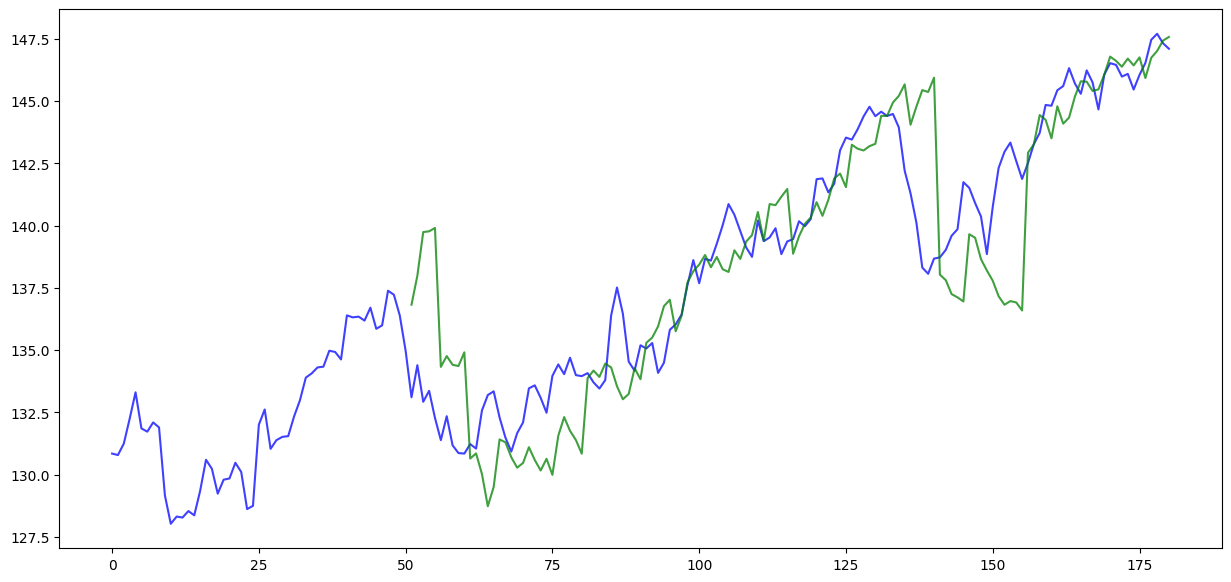

In [43]:
from plot import pred_vs_real_plot
pred_vs_real_plot(df_daily, PAIR , x_axis, y, validation, n_test)    

## Predict the next two weeks

In [44]:
predictions = est.fit(y).predict()

In [45]:
predictions = predictions.to_frame(name='Adj Close').reset_index(names='date')

predictions['tag'] = 'prediction'

# round prediction values
predictions['Adj Close'] = predictions['Adj Close'].apply(lambda x: round(x,2))

all_df = pd.concat([predictions, original_data]).sort_values(by='date')




In [46]:
## create the reality dataset
df_daily_plus_two = get_daily_data(PAIR, START, '2023-09-14')

df_daily_plus_two = df_daily_plus_two.reset_index(names='Date')

df_daily_plus_two = df_daily_plus_two.tail(15)

[*********************100%%**********************]  1 of 1 completed


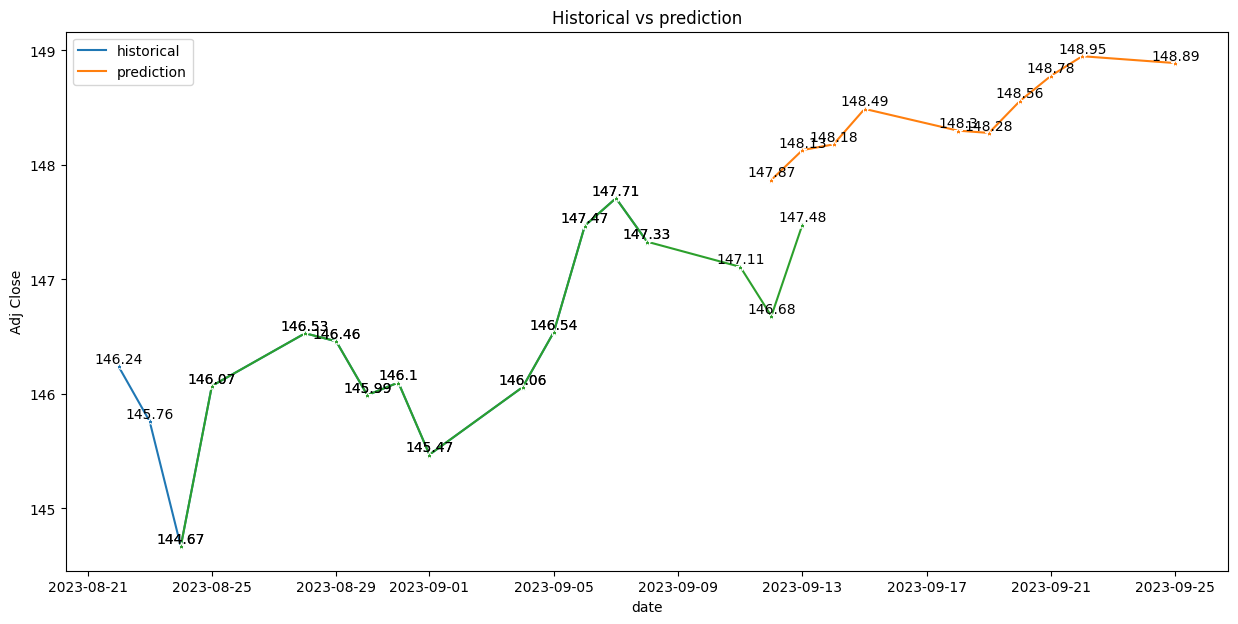

In [47]:
import seaborn as sns
plt.figure(figsize=(15,7))


ax = sns.lineplot(x = 'date', y = 'Adj Close', marker='*',  data = all_df,  hue='tag') 
# sns.lineplot(x = 'Date', y = 'Adj Close', marker='*',  data = df_daily_plus_one.reset_index())

ax.set(title='Historical vs prediction')

ax2 = sns.lineplot(x = 'Date', y = 'Adj Close', marker='*',  data = df_daily_plus_two)

# data labels
for i, j in zip(all_df.date, all_df['Adj Close']):
    plt.text(i, j, str(j), ha='center', va='bottom')
    
for i, j in zip(df_daily_plus_two.Date, df_daily_plus_two['Adj Close']):
    plt.text(i, j, str(j), ha='center', va='bottom')    